# Homework2: Normalizing flows and VAE

```your solution```

In [1]:
COMMIT_HASH = "79dfd7865ba692235f0a4d5aed20ee2820a19007"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

!pip install einops

-d was unexpected at this time.


e:\nau\ML_courses_GenAI_NLP\scientificProject\GenAI\hw2\dgm_utils


fatal: destination path 'dgm_utils' already exists and is not an empty directory.
HEAD is now at 79dfd78 Make binarized images default type long


Defaulting to user installation because normal site-packages is not writeable
Processing e:\nau\ml_courses_genai_nlp\scientificproject\genai\hw2\dgm_utils
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for dgm-utils: filename=dgm_utils-0.1.1-py3-none-any.whl size=6167 sha256=98d71330b4d2ae83dc006ec81fb14be3a9d4f42e794d559656750354f8cc65e4
  Stored in directory: C:\Users\twoli\AppData\Local\Temp\pip-ephem-wheel-cache-qmo1m4e_\wheels\7d\4b\fc\eaae628dc34d3f61b88ef353168b1a70e0c3dc165a1197a0a8
Successfully built dgm-utils
  Attempting uninstall: dgm-utils
    Found existing installation: dgm-utils 0.1.1
    Uninstalling dgm-utils-0.1.1:
      Successfully uninstalled dgm-utils-0.1.1
e:\nau\ML_courses_GenAI_NLP\scientificProject\GenAI\hw2


'rm' is not recognized as an internal or external command,
operable program or batch file.


Defaulting to user installation because normal site-packages is not writeable


In [2]:
from dgm_utils import train_model
from dgm_utils import show_samples, visualize_images, load_dataset
from dgm_utils import BaseModel

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import einsum

if torch.cuda.is_available():
    DEVICE = "cuda"
    print("GPU found :)")
else:
    DEVICE = "cpu"
    print("GPU not found :(")

GPU found :)


In [4]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)


class PreNorm(nn.Module):
    def __init__(self, dim: int, fn: nn.Module) -> None:
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),  # nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim: int, heads: int = 4, dim_head: int = 64, dropout: float = 0.0) -> None:
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head**-0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout)) if project_out else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, _, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=h), qkv)

        dots = einsum("b h i d, b h j d -> b h i j", q, k) * self.scale

        attn = self.attend(dots)

        out = einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim: int, depth: int, heads: int, dim_head: int, mlp_dim: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                        PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)),
                    ]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class ViTEncoder(nn.Module):
    def __init__(
        self,
        *,
        image_shape: tuple[int, int] | int,
        patch_shape: tuple[int, int] | int,
        dim: int,
        depth: int,
        heads: int,
        mlp_dim: int,
        n_channels: int = 3,
        dim_head: int = 64,
        dropout: float = 0.0,
        emb_dropout: float = 0.0,
    ) -> None:
        super().__init__()
        # ====
        # your code
        patch_height = patch_shape[0]
        patch_width = patch_shape[1]
        patch_dim  = n_channels * patch_height * patch_width

        image_height = image_shape[0]
        image_width = image_shape[1]

        num_patches = (image_height // patch_height) * (image_width // patch_width)

        # 1) create embedder for patches
        self.to_patch_emb = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )
        # 2) create positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_emb = nn.Parameter(torch.rand(1, num_patches + 1, dim))
        self.dim = dim
        # 3) create transformer
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout=dropout)
        # ====

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) patch image and compute embeddings
        x = self.to_patch_emb(img)
        b, n, _ = x.shape
        # 2) compute positional embeddings
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_emb[:, :(n + 1)]
        # 3) apply transformer and get representations for each patch
        x = self.transformer(x)
        # ====
        return x

## Task 3: ViTVAE on CIFAR10 data (5pt)

In this task you will implement VAE model for CIFAR10 dataset.

Let download and visualize samples from the dataset.

Files already downloaded and verified
Files already downloaded and verified


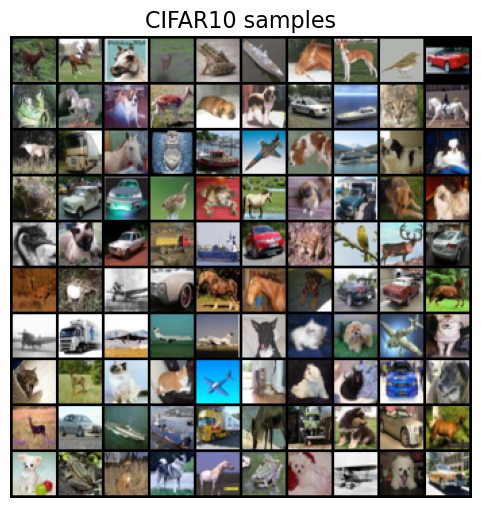

In [5]:
train_data, test_data = load_dataset("cifar10", flatten=False, binarize=False)
visualize_images(train_data, "CIFAR10 samples")

Now it is time to define our model. Our model will have the following structure:

* Prior distribution is standard Normal ($p(\mathbf{z}) = \mathcal{N}(0, I)$).
* Variational posterior distribution (or encoder) is $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$. Here $\boldsymbol{\phi}$ denotes all parameters of the encoder neural network. We will assume that covariance matrice $\boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x})$ is diagonal.
* Generative distribution (or decoder) is $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$. Here $\boldsymbol{\theta}$ denotes all parameters of the decoder neural network. Please note, that here we will use continuous distribution for our variables $\mathbf{x}$.
* We do not fit the covariance matrix $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ in the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$. We assume that it is identical ($\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{I}$). We will use the $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z})$ (mean of the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$) as model samples.
* Our encoder and decoder will be convolutional neural networks.
* Model objective is slightly modified ELBO:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - \beta * KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$
Here we introduce the parameter $\beta$. It reweights KL term in the total loss. It a standard heuristics that allows to get more accurate model. In this exercise you have to play with it, starting with the value $\beta = 1$ (standard ELBO).

To make the expectation is independent of parameters $\boldsymbol{\phi}$, we will use reparametrization trick.


To calculate the loss, we should derive
- $\log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$, note that generative distribution is $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$.
- KL between $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$ and $\mathcal{N}(0, \mathbf{I})$.

Let start with the helper functions.

In [6]:
from typing import Optional

# Реализация функции get_normal_KL
def get_normal_KL(
    mean_1: torch.Tensor,
    log_std_1: torch.Tensor,
    mean_2: Optional[torch.Tensor] = None,
    log_std_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    :Parameters:
    mean_1: means of normal distributions (1)
    log_std_1 : standard deviations of normal distributions (1)
    mean_2: means of normal distributions (2)
    log_std_2 : standard deviations of normal distributions (2)
    :Outputs:
    kl divergence of the normal distributions (1) and normal distributions (2)
    ---
    This function should return the value of KL(p1 || p2),
    where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
    If mean_2 and log_std_2 are None values, we will use standard normal distribution.
    Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape
    
    # KL divergence formula for normal distributions with diagonal covariance:
    # KL(p1 || p2) = 0.5 * Σ[log(σ₂²/σ₁²) + σ₁²/σ₂² + (μ₁ - μ₂)²/σ₂² - 1]
    
    # Convert log_std to std (standard deviation)
    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)
    
    # Calculate KL divergence term by term
    # log(σ₂²/σ₁²) = 2*log(σ₂) - 2*log(σ₁) = 2*log_std_2 - 2*log_std_1
    log_ratio = 2 * (log_std_2 - log_std_1)
    
    # σ₁²/σ₂² = (std_1/std_2)²
    var_ratio = (std_1 / std_2) ** 2
    
    # (μ₁ - μ₂)²/σ₂² = (mean_1 - mean_2)² / std_2²
    mean_diff_squared = (mean_1 - mean_2) ** 2 / (std_2 ** 2)
    
    # Combine all terms: 0.5 * (log_ratio + var_ratio + mean_diff_squared - 1)
    kl_divergence = (log_ratio + var_ratio + mean_diff_squared - 1)
    
    # Sum over all dimensions
    return 0.5 * kl_divergence


def test_KL():
    assert np.isclose(
        get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)).numpy(),
        200.2144,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)).numpy(),
        1.50925,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_KL(torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))).numpy(),
        [49.2990, 1498.479],
        rtol=1e-3,
    )


test_KL()

In [7]:
def get_normal_nll(x: torch.Tensor, mean: torch.Tensor, log_std: torch.Tensor) -> torch.Tensor:
    """
    This function should return the negative log likelihood log p(x),
    where p(x) = Normal(x | mean, exp(log_std) ** 2).
    Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    # your code
    # log N(x|μ,σ²) = -½[(x-μ)²/σ² + log(2πσ²)]
    std_sq = log_std.exp()**2
    term1 = (x - mean) ** 2 / std_sq
    term2 = torch.log( torch.tensor(2 * torch.pi) * std_sq)
    nll = 0.5 * (term1 + term2)
    return nll 
    # ====


def test_NLL():
    assert np.isclose(
        get_normal_nll(torch.tensor(2), torch.tensor(2), torch.tensor(3)).numpy(),
        3.9189,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_nll(torch.tensor(5), torch.tensor(-3), torch.tensor(6)).numpy(),
        6.9191,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_nll(torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))).numpy(),
        np.array([3.9982, 5.9197]),
        rtol=1e-3,
    )


test_NLL()

Let define our encoder and decoder neural networks. We will use ViT-like encoder and decoder.. `ViTEncoderVAE` closely resembles `ViTAffineConditioner`; however, it returns the mean $\mu$ and log-variance $\log\sigma$ rather than $s$ and $t$.

In [43]:
class ViTEncoderVAE(nn.Module):
    def __init__(self, vit: ViTEncoder, latent_dim: int) -> None:
        super().__init__()
        # ====
        # your code
        # create neural network that transforms patch embeddings from ViTEncoder to mu and log_std
        self.vit = vit
        
        # Get dimensions from ViT encoder
        vit_dim = vit.dim
        
        # Create heads for s and t transformations
        
        self.mean_head = nn.Sequential(
            nn.Linear(vit_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )
        
        self.log_std_head = nn.Sequential(
            nn.Linear(vit_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) Get embeddings per patch via ViTEncoder
        x = self.vit(x)  
        
        # Remove CLS token (first token)
        patch_embeddings = x[:, 1:, :]  # Shape: (batch_size, num_patches, dim)
        
        # 2) Compute mu and logvar
        mu = self.mean_head(patch_embeddings)  # Shape: (batch_size, num_patches, patch_dim)
        log_std = self.log_std_head(patch_embeddings)  # Shape: (batch_size, num_patches, patch_dim)

        # ====
        return mu.mean(dim=1), log_std.mean(dim=1)

Look at this piece of code carefully.

In [44]:
class ViTDecoderVAE(nn.Module):
    def __init__(
        self,
        *,
        image_shape: tuple[int, int] | int,
        patch_shape: tuple[int, int] | int,
        dim: int,
        depth: int,
        heads: int,
        mlp_dim: int,
        n_channels: int = 3,
        dim_head: int = 64,
        dropout: float = 0.0,
        emb_dropout: float = 0.0,
    ) -> None:
        super().__init__()
        image_height, image_width = pair(image_shape)
        patch_height, patch_width = pair(patch_shape)

        assert (
            image_height % patch_height == 0 and image_width % patch_width == 0
        ), "Image dimensions must be divisible by the patch size."

        self.num_patches = (image_height // patch_height) * (image_width // patch_width)
        self.patch_height, self.patch_width = patch_height, patch_width
        self.n_channels = n_channels
        self.image_height = image_height
        self.image_width = image_width
        self.dim = dim

        # Expand latent vector into patch tokens
        self.latent_to_tokens = nn.Linear(dim, self.num_patches * dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        # Project patch embeddings back to pixels
        patch_dim = n_channels * patch_height * patch_width
        self.to_pixels = nn.Linear(dim, patch_dim)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        b, _ = z.shape
        # Expand single latent into sequence of tokens
        x = self.latent_to_tokens(z).reshape(b, self.num_patches, self.dim)
        x += self.pos_embedding
        x = self.dropout(x)

        x = self.transformer(x)

        # project tokens back to patches
        patches = self.to_pixels(x)

        # reconstruct image
        img = rearrange(
            patches,
            "b (h w) (p1 p2 c) -> b c (h p1) (w p2)",
            h=self.image_height // self.patch_height,
            w=self.image_width // self.patch_width,
            p1=self.patch_height,
            p2=self.patch_width,
            c=self.n_channels,
        )
        return img

We are ready to implement VAE model for image dataset.

In [45]:
class ViTVAE(BaseModel):
    def __init__(
        self,
        n_latent: int,
        encoder: ViTEncoderVAE,
        decoder: ViTDecoderVAE,
        beta: float = 1,
    ) -> None:
        super().__init__()

        self.n_latent = n_latent
        self.beta = beta

        self.encoder = encoder
        self.decoder = decoder

    def prior(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # return n samples from prior distribution (we use standart normal for prior)
        # ====
        z = torch.randn(n, self.n_latent)
        z = z.to(self.device)
        return z

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # 1) apply encoder to get mu_z, log_std_z
        mu_z, log_std_z = self.encoder(x)
        # 2) apply reparametrization trick (use self.prior)
        std = torch.exp(0.5 * log_std_z)
        eps = torch.randn_like(std)
        z = mu_z + std * eps
        
        # 3) apply decoder to get mu_x (which corresponds to reconstructed x)
        x_recon = self.decoder(z)
        # ====
        return mu_z, log_std_z, x_recon

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # 1) make forward step to get mu_z, log_std_z, x_recon
        mu_z, log_std_z, x_recon = self.forward(x)
        # 2) calculate recon_loss (use get_normal_nll)
        log_std = torch.log(torch.ones_like(x_recon))
        recon_loss = get_normal_nll(x, x_recon, log_std).sum()
        # 3) calcucalte kl_loss (use get_normal_KL)
        kl_loss = get_normal_KL(mu_z, log_std_z).sum()

        # ====
        return {
            "elbo_loss": recon_loss + self.beta * kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            # ====
            # your code
            # 1) generate prior samples
            z = self.prior(n)
            # 2) apply decoder
            x_recon = self.decoder(z)
            # ====
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

That is all! We are ready to train our model.

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 10
EPOCHS = 10
LR = 1e-2
N_LATENS = 32
BETA = 0.5
SCHEDULER_GAMMA = 1
# ====

# we center the data, because it helps the model to fit
centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

In [50]:
DIM = 256
DEPTH = 8
HEADS = 4
MLP_DIM = 128

image_shape = (32, 32)
patch_shape = (4, 4)
vit = ViTEncoder(
    image_shape=image_shape,
    patch_shape=patch_shape,
    dim=DIM,
    depth=DEPTH,
    heads=HEADS,
    mlp_dim=MLP_DIM,
    n_channels=3,
)
vit_encoder_vae = ViTEncoderVAE(
    vit,
    N_LATENS,
)
vit_decoder_vae = ViTDecoderVAE(
    image_shape=image_shape,
    patch_shape=patch_shape,
    dim=N_LATENS,
    depth=DEPTH,
    heads=HEADS,
    mlp_dim=MLP_DIM,
    n_channels=3,
)

model = ViTVAE(N_LATENS, vit_encoder_vae, vit_decoder_vae, beta=BETA)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=SCHEDULER_GAMMA)

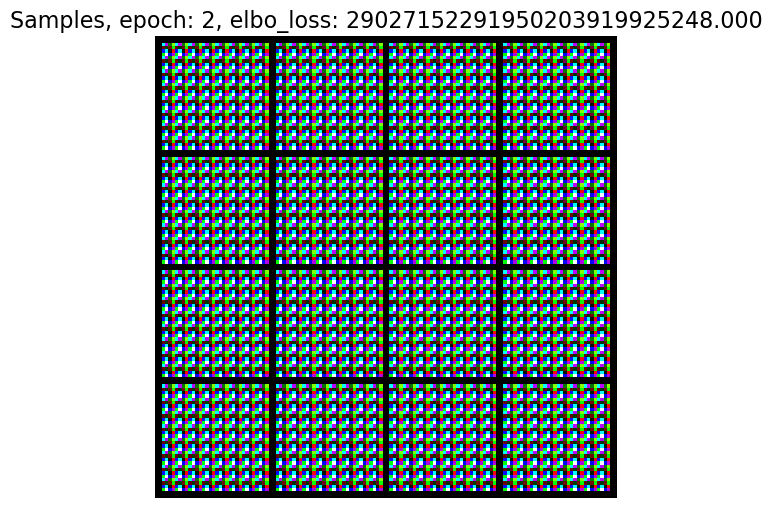

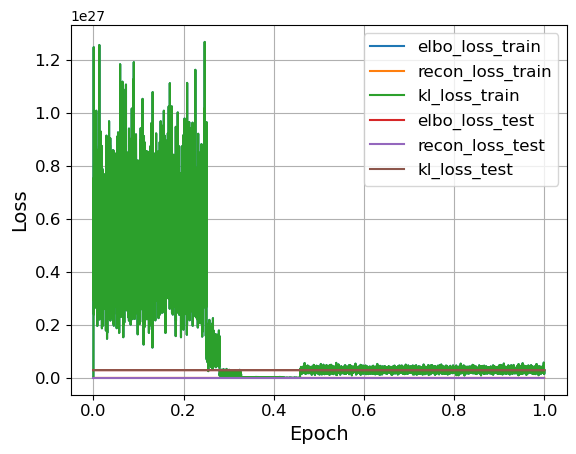

Training epoch 3:   0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [51]:
train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    loss_key="elbo_loss",
)

Now we could visualize the model outputs.

1. We could sample new images from our model (sample latent variable from the prior and apply the decoder).
2. We could visualize image reconstructions (apply the encoder and the decoder to the fixed image).
3. Visualize interpolations (apply the encoder to two images $\mathbf{x}_1$ and $\mathbf{x}_2$ to obtain the latent variables $\mathbf{z}_1$ and $\mathbf{z}_2$, apply the decoder to the latent variables $\mathbf{z}$ lying on the segment between $\mathbf{z}_1$ and $\mathbf{z}_2$).

**Note:** it is ok that your samples are blurry. We do not use difficult architectures and do not tune hyperparameters carefully.

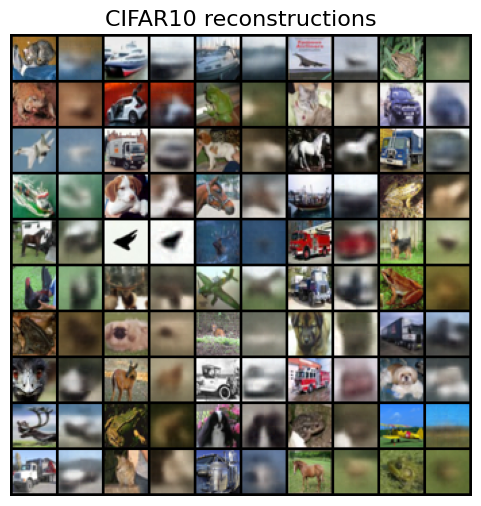

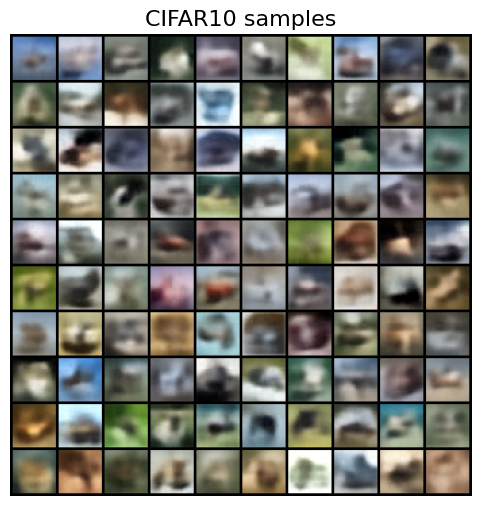

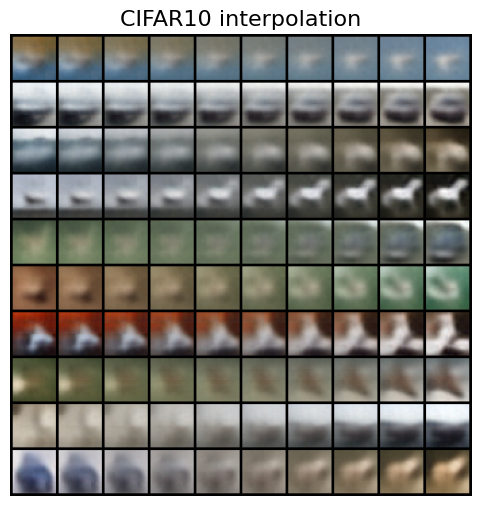

In [ ]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]

x = x.to(model.device)

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20]
x = x.to(model.device)
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, "CIFAR10 reconstructions")
show_samples(samples, "CIFAR10 samples")
show_samples(interps, "CIFAR10 interpolation")